In [1]:
import numpy as np
from PIL import Image
import os
import glob

from utils.models import load_sam, load_owl
import torch
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from utils.mask import show_mask, show_points, show_box

/data/sangwon/anaconda3/envs/mudi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
predictor = load_sam("vit_h", 'cuda')
processor, model = load_owl('cuda')

In [3]:
def add_margin(input_box, target_sizes, m=0.1):
    # Add margin to the input box
    x1, y1, x2, y2 = input_box
    w, h = target_sizes
    w_margin = int(w * m)
    h_margin = int(h * m)

    x1 = max(0, x1 - w_margin)
    y1 = max(0, y1 - h_margin)
    x2 = min(w, x2 + w_margin)
    y2 = min(h, y2 + h_margin)

    return np.array([x1, y1, x2, y2])


In [4]:
image_dir = 'dataset/category/actionfigure_2_and_dog0'
image_paths = glob.glob(os.path.join(image_dir, '*.jpg'))

owl_query_dict = {"a": "action figure", "b": "dog"}

owl_threshold = 0.2

In [5]:
# some errors in high-res images (OWLv2 error)
fails = []
for image_path in image_paths:

    basename = os.path.basename(image_path)
    category = basename[0] # a or b
    owl_query = owl_query_dict[category]

    img = Image.open(image_path).convert('RGB')
    inputs = processor(text=[owl_query], images=img, return_tensors="pt").to('cuda')
    with torch.no_grad():
        outputs = model(**inputs)

    target_sizes = torch.Tensor([img.size[::-1]])
    results = processor.post_process_object_detection(
        outputs=outputs, 
        target_sizes=target_sizes, 
        threshold=owl_threshold,
    )
    boxes  = results[0]["boxes"]
    boxes = np.array(boxes.cpu().detach())

    if len(boxes) != 1:
        print(f"{basename}: not single object error")
        fails.append(image_path)
        continue
    else:
        input_box = boxes[0]
        input_box = add_margin(input_box, img.size[::-1], 0.05)
        predictor.set_image(np.array(img))
        masks, _, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],
            multimask_output=False,
        )
        mask = Image.fromarray(masks[0].astype(np.uint8) * 255)
        mask.save(os.path.join(image_dir, f'mask_{basename}'))

a00.jpg: not single object error
a03.jpg: not single object error
a02.jpg: not single object error
a01.jpg: not single object error
a04.jpg: not single object error


### Manual segmentation with SAM

(2986, 3381)


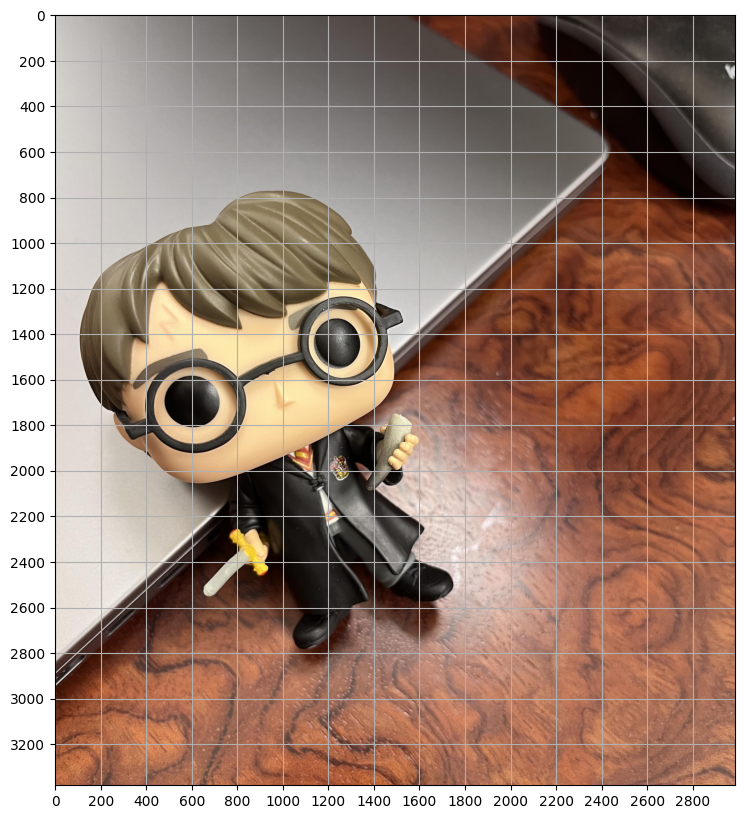

In [6]:
IDX = 0
image_path = fails[IDX]
image = Image.open(image_path)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.grid()
plt.plot()
ax = plt.gca()  # Get current axis
tick = 200
ax.xaxis.set_major_locator(MultipleLocator(tick))
ax.yaxis.set_major_locator(MultipleLocator(tick))
print(image.size)

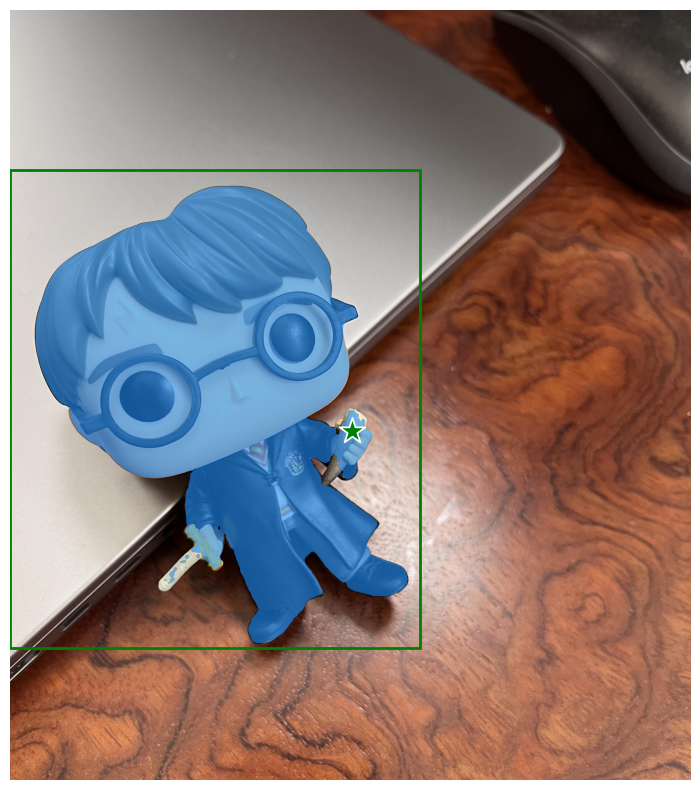

In [7]:
# TODO: x1, x2, y1, y2
BBOX = (0, 1800, 700, 2800)
# point_labels = None
point_labels = np.array([1])
# point_coords = None
point_coords = np.array([[1500, 1850]])

coords = BBOX
x1, x2, y1, y2 = coords
input_box = np.array([x1, y1, x2, y2])

predictor.set_image(np.array(image))
masks, _, _ = predictor.predict(
    point_coords=point_coords,
    point_labels=point_labels,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())

if point_coords is not None:
    show_points(point_coords, point_labels, plt.gca())
    
plt.axis('off')
plt.show()

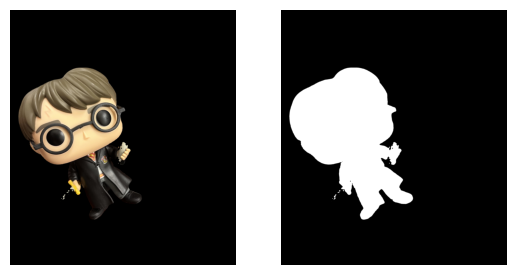

In [8]:
# visualize sample
seg = Image.fromarray(np.array(image) * np.array(masks[0])[:, :, None])
mask = Image.fromarray(masks[0].astype(np.uint8) * 255)

plt.subplot(1, 2, 1)
plt.imshow(seg)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

In [9]:
basename = os.path.basename(image_path)
mask_save_path = os.path.join(image_dir, f'mask_{basename}')
mask.save(mask_save_path)